In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import scipy, scipy.misc, scipy.signal
from PIL import Image
import PIL
import cv2
import sys

In [2]:
def computeTextureWeights(fin, sigma, sharpness):
    dt0_v = np.vstack((np.diff(fin, n=1, axis=0), fin[0,:]-fin[-1,:]))
    dt0_h = np.vstack((np.diff(fin, n=1, axis=1).conj().T, fin[:,0].conj().T-fin[:,-1].conj().T)).conj().T

    gauker_h = scipy.signal.convolve2d(dt0_h, np.ones((1,sigma)), mode='same')
    gauker_v = scipy.signal.convolve2d(dt0_v, np.ones((sigma,1)), mode='same')

    W_h = 1/(np.abs(gauker_h)*np.abs(dt0_h)+sharpness)
    W_v = 1/(np.abs(gauker_v)*np.abs(dt0_v)+sharpness)

    return  W_h, W_v
    

In [3]:
def solveLinearEquation(IN, wx, wy, lamda):
    [r, c] = IN.shape
    k = r * c
    dx =  -lamda * wx.flatten('F')
    dy =  -lamda * wy.flatten('F')
    tempx = np.roll(wx, 1, axis=1)
    tempy = np.roll(wy, 1, axis=0)
    dxa = -lamda *tempx.flatten('F')
    dya = -lamda *tempy.flatten('F')
    tmp = wx[:,-1]
    tempx = np.concatenate((tmp[:,None], np.zeros((r,c-1))), axis=1)
    tmp = wy[-1,:]
    tempy = np.concatenate((tmp[None,:], np.zeros((r-1,c))), axis=0)
    dxd1 = -lamda * tempx.flatten('F')
    dyd1 = -lamda * tempy.flatten('F')
    
    wx[:,-1] = 0
    wy[-1,:] = 0
    dxd2 = -lamda * wx.flatten('F')
    dyd2 = -lamda * wy.flatten('F')
    
    Ax = scipy.sparse.spdiags(np.concatenate((dxd1[:,None], dxd2[:,None]), axis=1).T, np.array([-k+r,-r]), k, k)
    Ay = scipy.sparse.spdiags(np.concatenate((dyd1[None,:], dyd2[None,:]), axis=0), np.array([-r+1,-1]), k, k)
    D = 1 - ( dx + dy + dxa + dya)
    A = ((Ax+Ay) + (Ax+Ay).conj().T + scipy.sparse.spdiags(D, 0, k, k)).T
    
    tin = IN[:,:]
    tout = scipy.sparse.linalg.spsolve(A, tin.flatten('F'))
    OUT = np.reshape(tout, (r, c), order='F')
    
    return OUT

In [4]:
def tsmooth(img, lamda=0.01, sigma=3.0, sharpness=0.001):
    I = cv2.normalize(img.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    x = np.copy(I)
    wx, wy = computeTextureWeights(x, sigma, sharpness)
    S = solveLinearEquation(I, wx, wy, lamda)
    return S

In [5]:
def rgb2gm(I):
    if (I.shape[2] == 3):
        I = cv2.normalize(I.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)
        I = np.abs((I[:,:,0]*I[:,:,1]*I[:,:,2]))**(1/3)

    return I

In [6]:
def applyK(I, k, a=-0.3293, b=1.1258):
    f = lambda x: np.exp((1-x**a)*b)
    beta = f(k)
    gamma = k**a
    J = (I**gamma)*beta
    return J

In [7]:
def entropy(X):
    tmp = X * 255
    tmp[tmp > 255] = 255
    tmp[tmp<0] = 0
    tmp = tmp.astype(np.uint8)
    _, counts = np.unique(tmp, return_counts=True)
    pk = np.asarray(counts)
    pk = 1.0*pk / np.sum(pk, axis=0)
    S = -np.sum(pk * np.log2(pk), axis=0)
    return S

In [11]:
def maxEntropyEnhance(I, isBad, a=-0.3293, b=1.1258):
    # Esatimate k
    tmp = cv2.resize(I, (50,50), interpolation=cv2.INTER_AREA)
    tmp[tmp<0] = 0
    tmp = tmp.real
    Y = rgb2gm(tmp)
    
    isBad = isBad * 1
    isBad = np.array(Image.fromarray(isBad.astype('uint8')).resize((50,50), resample=Image.BICUBIC))

    isBad[isBad<0.5] = 0
    isBad[isBad>=0.5] = 1
    Y = Y[isBad==1]
    
    if Y.size == 0:
       J = I
       return J
    
    f = lambda k: -entropy(applyK(Y, k))
    opt_k = scipy.optimize.fminbound(f, 1, 7)
    
    # Apply k
    J = applyK(I, opt_k, a, b) - 0.01
    return J

In [31]:
def fusion(img, mu=0.5, a=-0.3293, b=1.1258):
    lamda = 0.5
    sigma = 5
    I = cv2.normalize(img.astype('float64'), None, 0.0, 1.0, cv2.NORM_MINMAX)

    # Weight matrix estimation
    t_b = np.max(I, axis=2)
    t_our = cv2.resize(tsmooth(np.array(Image.fromarray(t_b).resize((int(t_b.shape[0]/2), int(t_b.shape[0]/2)), resample=Image.BICUBIC)), lamda, sigma), (t_b.shape[1], t_b.shape[0]), interpolation=cv2.INTER_AREA)

    
    # Apply camera model with k(exposure ratio)
    isBad = t_our < 0.5
    J = maxEntropyEnhance(I, isBad)

    # W: Weight Matrix
    t = np.zeros((t_our.shape[0], t_our.shape[1], I.shape[2]))
    for i in range(I.shape[2]):
        t[:,:,i] = t_our
    W = t**mu
    plt.subplot(1,3,1)
    plt.imshow(W)
    #plt.show()
    plt.subplot(1,3,2)
    plt.imshow(J)
    #plt.show()
    plt.subplot(1,3,3)
    plt.imshow(1-W)
    plt.show()
    I2 = I*W
    J2 = J*(1-W)

    result = I2 + J2
    result = result * 255
    result[result > 255] = 255
    result[result<0] = 0
    return result.astype(np.uint8)

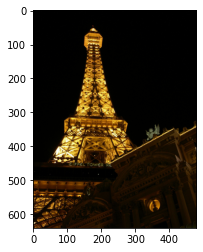

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


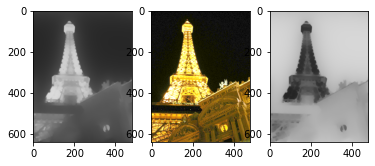

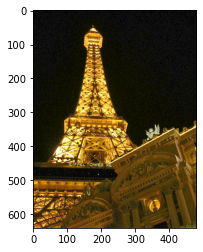

In [35]:
img_name = "/Users/gokulkumar/IPCV_Project/test_01.jpg"
img = imageio.imread(img_name)
plt.imshow(img)
plt.show()
result = fusion(img)
plt.imshow(result)
plt.show()


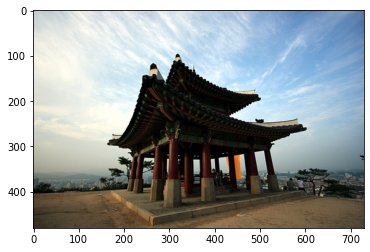

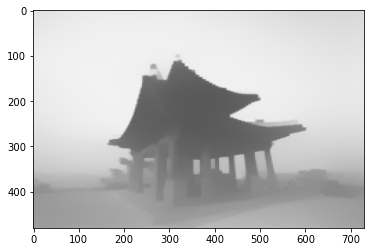

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


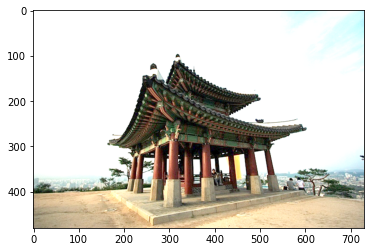

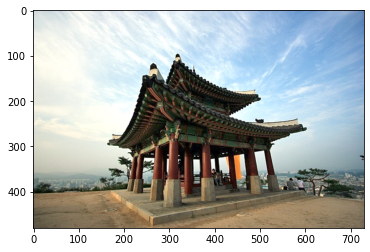

In [26]:
img_name = "/Users/gokulkumar/IPCV_Project/test_02.jpg"
img = imageio.imread(img_name)
plt.imshow(img)
plt.show()
result = fusion(img)
plt.imshow(result)
plt.show()


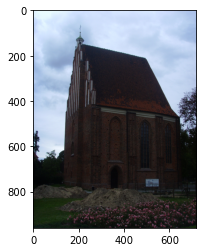

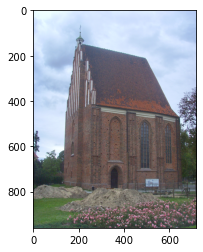

In [22]:
img_name = "/Users/gokulkumar/IPCV_Project/test_03.jpg"
img = imageio.imread(img_name)
plt.imshow(img)
plt.show()
result = fusion(img)
plt.imshow(result)
plt.show()

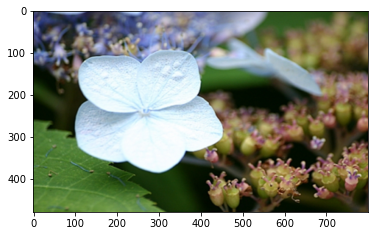

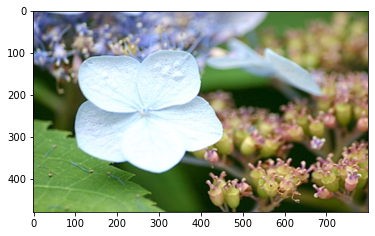

In [23]:
img_name = "/Users/gokulkumar/IPCV_Project/test_04.jpg"
img = imageio.imread(img_name)
plt.imshow(img)
plt.show()
result = fusion(img)
plt.imshow(result)
plt.show()
